In [27]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Option Pricing with Neural Networks

In this project, we aim to see how well a neural network can approximate the price of an option undercertain models, first we compare it with the analytical form of a Black Scholes call, then we'll see how it performs on different models like Heston where we will generate the price numerically and train the network on them.

The first step in any ML project is to well define the setup, so our features and our target variable.

## Part 1: Finding Black Scholes Call Prices with Neural Network - Analytical Form

Let us define the input features $\mathbf{x} \in \mathbb{R}^6$ as:

- $S$ : Current stock price
- $K$ : Strike price of the option
- $T$ : Time to maturity
- $r$ : Risk-free interest rate
- $r$ : continuous dividend yield
- $\sigma$ : Volatility of the underlying asset

These features are sufficient to compute the theoretical Black-Scholes price for a European call option with dividends.

We denote the feature vector as:

$$
\mathbf{x} = [S, K, T, r, q, \sigma]
$$


The target **Y** is the **Black-Scholes price of the European call** option with continuous dividend yield, denoted by:

$$
y = S e^{-qT} \cdot \Phi(d_1) - K e^{-rT} \cdot \Phi(d_2)
$$

We can define the loss function as follow:

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \left( C_{i} - f_\theta(\mathbf{x}^{(i)}) \right)^2
$$

where:

- $\theta$ are the trainable parameters of the neural network,
- $f_\theta(\mathbf{x}^{(i)}) = \hat{y}^{(i)}$ is the model prediction for input $\mathbf{x}^{(i)}$,
- $C_{i}$ is the target value, i.e., the Black-Scholes price for that input,
- $N$ is the number of training samples.

We take the mean so that the gradient is independant of the sample size and it makes it more stable.

In [2]:
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

# eg for one price given the 6 parameters
S, K, T, r, q, sigma = 100, 100, 1, 0.05, 0, 0.2
black_scholes_call(S, K, T, r, q, sigma)

10.450583572185565

Now we generate 5000 x 6 parameters as inputs and compute the analytical 5000 correponding prices that we use to train the network

In [3]:
## Dataset generation
n_samples = 5000
S = np.random.uniform(80, 120, n_samples)
K = np.random.uniform(80, 120, n_samples)
T = np.random.uniform(0.1, 2.0, n_samples)
sigma = np.random.uniform(0.1, 0.5, n_samples)
r = np.random.uniform(0.0, 0.05, n_samples)
q = np.random.uniform(0.0, 0.03, n_samples)

X = np.stack([S, K, T, sigma, r, q], axis=1)
y = black_scholes_call(S, K, T, sigma, r, q)

# Feature normalization for better gradient learning
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_tensor = torch.tensor(X_norm, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

Backpropagation on weights and biases on a mini batch of size B for a layer n

<img src="Backpropagation.jpeg" alt="Backpropagation" width="50%"/>



In [4]:
class BlackScholesNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(6, 64)     # 6 inputs → 64
        self.hidden2 = nn.Linear(64, 64)    # 64 → 64
        self.output = nn.Linear(64, 1)      # 64 → 1 (le prix)

        self.activation = nn.ReLU()         

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.output(x)                  
        return x

model = BlackScholesNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()                           
    
    optimizer.zero_grad()                 
    outputs = model(X_tensor)              
    loss = criterion(outputs, y_tensor)    

    loss.backward()                     
    optimizer.step()                        

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 896.0850


In [5]:
with torch.no_grad():
    preds = model(X_tensor)
    preds_np = preds.numpy()

example_idx = np.random.randint(0, n_samples, 3)


print('Now comparing the real analytical prices with what the Neural Network learned for 3 randomly chosen prices\n')
for i in example_idx:
    params = X[i]
    print(f"Set {i}: S={params[0]:.2f}, K={params[1]:.2f}, T={params[2]:.2f}, "
          f"σ={params[3]:.2f}, r={params[4]:.2f}, q={params[4]:.2f}")
    print(f"   True Price      : {y[i]:.2f}")
    print(f"   NN Prediction   : {preds_np[i][0]:.2f}\n")


Now comparing the real analytical prices with what the Neural Network learned for 3 randomly chosen prices

Set 4027: S=105.43, K=101.00, T=1.44, σ=0.49, r=0.01, q=0.01
   True Price      : 53.26
   NN Prediction   : 48.54

Set 2161: S=84.62, K=95.04, T=0.66, σ=0.41, r=0.02, q=0.02
   True Price      : 10.92
   NN Prediction   : 11.81

Set 2005: S=80.72, K=109.69, T=1.48, σ=0.11, r=0.02, q=0.02
   True Price      : 0.00
   NN Prediction   : 4.07



## Part 2 - Finding Price for Local Volatility Model - No analytical form

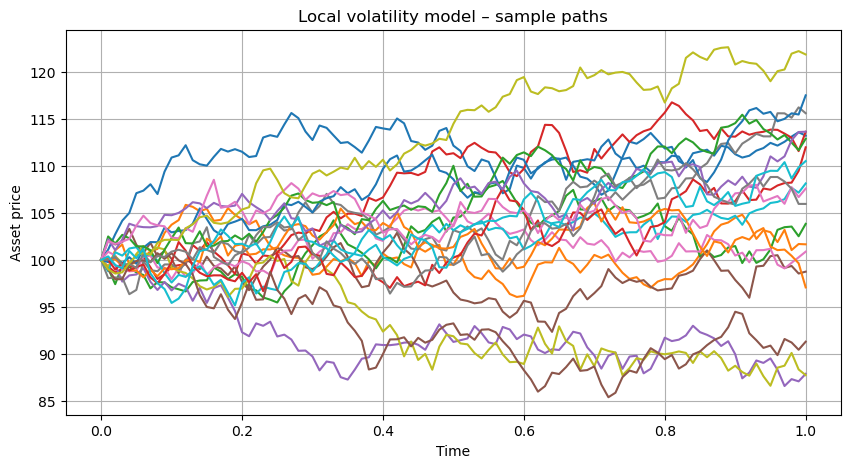

In [23]:
def sigma_loc(S, sigma_0, eps=1e-2):
    return sigma_0 / (S + eps)

def simulation_local_vol(S0, K, T, r, q, N, sigma_0, n_paths=500, return_paths=False):
    dt = T / N
    time_grid = np.linspace(0, T, N+1)
    S = np.zeros((n_paths, N+1))
    S[:, 0] = S0

    for i in range(N):
        sigma = sigma_loc(S[:, i], sigma_0)
        Z = np.random.normal(size=n_paths)
        S[:, i+1] = S[:, i] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Payoff for European Call
    payoffs = np.maximum(S[:, -1] - K, 0)
    discounted = np.exp(-r * T) * payoffs
    option_price = np.mean(discounted)

    if return_paths:
        return option_price, time_grid, S
    else:
        return option_price

price, time_grid, paths = simulation_local_vol(S0=100, K=100, T=1, r=0.05, q=0, N=100, sigma_0=10, return_paths=True)

plt.figure(figsize=(10, 5))
for i in range(20):
    plt.plot(time_grid, paths[i])
plt.title("Local volatility model – sample paths")
plt.xlabel("Time")
plt.ylabel("Asset price")
plt.grid(True)
plt.show()

And now the goal is to: 

- Take a set of parameters
- simulate N paths with them
- take the discounted mean of the payoffs to price the option corresponding to these parameters
- repeat for another set of parameters until we have enough option prices
- train the neural network on these prices to find a link between the parameters and the prices

In [36]:
n_samples = 2000
n_paths = 500
N = 100

S0_vals = np.random.uniform(80, 120, n_samples)
K_vals  = np.random.uniform(80, 120, n_samples)
T_vals  = np.random.uniform(0.1, 2.0, n_samples)
r_vals  = np.random.uniform(0.0, 0.1, n_samples)
q_vals  = np.random.uniform(0.0, 0.05, n_samples)
sigma_0_vals = np.random.uniform(5, 20, n_samples)

X = np.vstack([S0_vals, K_vals, T_vals, r_vals, q_vals, sigma_0_vals]).T
y = []

print('Computing numerical prices with Monte Carlo')
for i in tqdm(range(n_samples)):
    S0, K, T, r, q, sigma_0 = X[i]

    option_price = simulation_local_vol(S0, K, T, r, q, N, sigma_0, n_paths)
    y.append(option_price)

y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

class OptionPricingNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = OptionPricingNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

batch_size = 64
n_epochs = 50

for epoch in range(n_epochs):
    idx = torch.randperm(n_samples)

    for i in range(0, n_samples, batch_size):
        batch_idx = idx[i:i+batch_size]
        X_batch = X_tensor[batch_idx]
        y_batch = y_tensor[batch_idx]

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:02d} — Loss: {loss.item():.4f}")

idx = np.random.choice(n_samples, size=3, replace=False)
X_sample = X_tensor[idx]
y_sample = y_tensor[idx].squeeze().numpy()

model.eval()
with torch.no_grad():
    y_pred = model(X_sample).squeeze().numpy()

# Affichage des résultats
for i in range(3):
    print(f"Params: {X[idx[i]]}")
    print(f"Monte Carlo: {y_sample[i]:.4f} — NN: {y_pred[i]:.4f}")
    print("---")

Computing numerical prices with Monte Carlo


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 314.81it/s]


Epoch 00 — Loss: 87.1573
Epoch 10 — Loss: 6.5480
Epoch 20 — Loss: 6.5451
Epoch 30 — Loss: 2.2894
Epoch 40 — Loss: 10.3756
Epoch 49 — Loss: 3.9576
Params: [1.19988749e+02 1.08083028e+02 1.14732199e-01 4.03811754e-03
 1.35633820e-03 1.02613012e+01]
Monte Carlo: 11.8691 — NN: 11.2861
---
Params: [1.11660824e+02 9.08343724e+01 1.55044021e+00 6.91516294e-02
 4.69384980e-02 8.05134688e+00]
Monte Carlo: 22.5752 — NN: 23.5103
---
Params: [1.01464017e+02 1.02829829e+02 8.80963434e-01 8.71728827e-02
 2.77694218e-02 1.47188712e+01]
Monte Carlo: 7.5846 — NN: 6.1396
---
